# Introduction

This project focuses on **NLP Disaster Tweets** challenge, a Kaggle mini-project designed to leverage Natural Language Processing (NLP) techniques for disaster response. The ability to quickly and accurately identify disaster related tweets can enhance situational awareness, enabling swift resource allocation and targetted aid.

### Problem Description:
 The task is to build a machine learning model that can classify tweets as being about a real disaster (1) or not (0). This is a binary classification problem. The goal is to predict which tweets from the test set are about real disasters. The core problem lies in classifying tweets as either related to real disaster or not, a crucial task for emergency services and humanitarian organizations. 


# Dataset

This project uses the the Dataset provided on Kaggle at the link below. 
https://www.kaggle.com/c/nlp-getting-started/data

# Install Necessary Libraries

In [1]:
!pip install keras-nlp
!pip install torch
!pip install wordcloud
!pip install nltk
!pip install --upgrade pillow
!pip install --upgrade seaborn
!pip install --upgrade tensorflow

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import pickle
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
tf.autograph.experimental.do_not_convert

import gc
gc.collect()

27

# Data Loading


In [3]:
# Load data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Data Exploration and Cleanup

The following section explores the data and performs cleanup tasks such as selecting only numerical value, handling missing values, Remove URLs, special characters, lowercase, and stopwords.


Train data shape: (7613, 5)
Test data shape: (3263, 4)
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
Number of training samples: 7613
Number of test samples: 3263
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people re

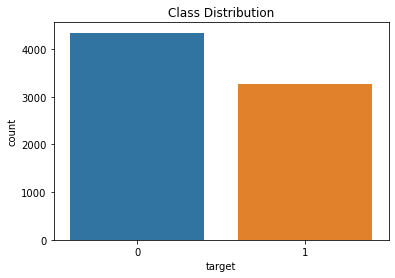

0    0.57034
1    0.42966
Name: target, dtype: float64


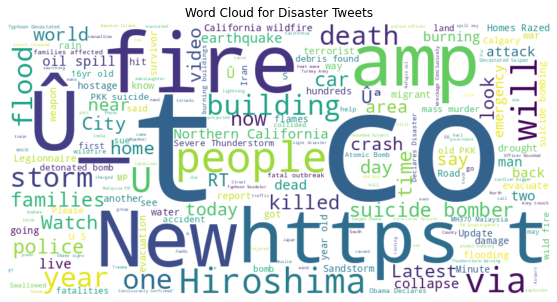

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


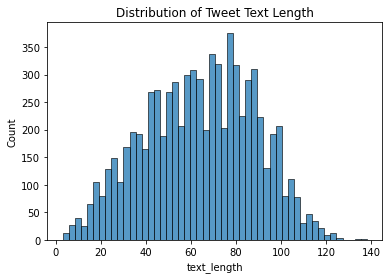

Common words in disaster tweets: [('fire', 180), ('news', 140), ('via', 121), ('disaster', 117), ('california', 111), ('suicide', 110), ('police', 107), ('amp', 107), ('people', 105), ('killed', 93), ('like', 92), ('pm', 89), ('hiroshima', 89), ('storm', 85), ('us', 84), ('crash', 84), ('fires', 84), ('families', 81), ('train', 79), ('emergency', 76)]
Common words in non-disaster tweets: [('like', 253), ('im', 248), ('amp', 193), ('new', 170), ('get', 163), ('dont', 154), ('one', 128), ('body', 113), ('via', 99), ('would', 97), ('video', 96), ('people', 91), ('love', 90), ('cant', 86), ('us', 86), ('time', 85), ('know', 85), ('back', 84), ('got', 83), ('see', 82)]
unknown                  61
fatalities               45
armageddon               42
deluge                   42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Leng

In [4]:
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Select only numerical columns
numerical_cols_train = train_data.select_dtypes(include=np.number).columns
numerical_cols_test = test_data.select_dtypes(include=np.number).columns

# Check for infinite values in numerical columns
if np.isinf(train_data[numerical_cols_train]).any().any():
    print("Warning: Infinite values found in numerical columns of train_data. Converting to NaN.")
    train_data[numerical_cols_train] = train_data[numerical_cols_train].replace([np.inf, -np.inf], np.nan)

if np.isinf(test_data[numerical_cols_test]).any().any():
    print("Warning: Infinite values found in numerical columns of test_data. Converting to NaN.")
    test_data[numerical_cols_test] = test_data[numerical_cols_test].replace([np.inf, -np.inf], np.nan)

# Inspect the data
print(train_data.head())
print(f"Number of training samples: {len(train_data)}")
print(f"Number of test samples: {len(test_data)}")

# Extract features and labels
X_train = train_data["text"].values
y_train = train_data["target"].values
X_test = test_data["text"].values

# Inspect data
print(train_data.head())
print(train_data.isnull().sum())

# Visualize class distribution
sns.countplot(x="target", data=train_data)
plt.title("Class Distribution")
plt.show()

# Print class imbalance.
print(train_data['target'].value_counts(normalize=True))

# Word Cloud for disaster tweets
disaster_tweets = train_data[train_data['target'] == 1]['text']
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(disaster_tweets))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Disaster Tweets")
plt.show()

# Handle missing values
train_data['keyword'].fillna('unknown', inplace=True)
test_data['keyword'].fillna('unknown', inplace=True)
train_data['location'].fillna('unknown', inplace=True)
test_data['location'].fillna('unknown', inplace=True)

# Data Cleaning: Remove URLs, special characters, lowercase, and stopwords
def preprocess_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.lower()
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

nltk.download('stopwords') #make sure the stopwords are downloaded.
train_data['text'] = train_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)

# Text Length Analysis
train_data['text_length'] = train_data['text'].apply(len)
sns.histplot(train_data['text_length'], bins=50)
plt.title('Distribution of Tweet Text Length')
plt.show()

# Common Words Analysis
def get_common_words(texts, n=20):
    all_words = ' '.join(texts)
    return Counter(all_words.split()).most_common(n)

disaster_words = get_common_words(train_data[train_data['target'] == 1]['text'])
non_disaster_words = get_common_words(train_data[train_data['target'] == 0]['text'])

print("Common words in disaster tweets:", disaster_words)
print("Common words in non-disaster tweets:", non_disaster_words)

# Keyword and Location Analysis
print(train_data['keyword'].value_counts())
print(train_data['location'].value_counts())

# Data Inspection

The section above also inspects the dataset.

**Train Data Shape**: (7613, 5): 
    This indicates that there are 7,613 training samples (tweets).
    Each sample has 5 columns: id, keyword, location, text, and target.

**Test Data Shape**: (3263, 4):
    This shows that there are 3,263 test samples.
    Each test sample has 4 columns: id, keyword, location, and text. Notice the absence of the target column, as this is what we will be predicting in this project.

**Columns**:
    id: A unique identifier for each tweet.
    keyword: A keyword from the tweet (61 missing vlaues in the dataset, represented as NaN).
    location: The location from which the tweet was sent (2533 missing values in the dataset).
    text: The actual text of the tweet. This is the primary data we will be using for NLP analysis.
    target: (Only in the training data) Indicates whether a tweet is about a real disaster (1) or not (0). This is the label our model will learn to predict.


**Target Variable Distribution**:

Class Imbalance: The target variable (disaster vs. non-disaster) shows a slight class imbalance:
Disaster tweets (1): ~43%
Non-disaster tweets (0): ~57%


**Common Words Analysis**:

Disaster Tweets:
Words like "fire," "disaster," "california," "suicide," and "killed" are frequently associated with disaster-related tweets.
This indicates that the dataset contains tweets related to various types of disasters.
Non-Disaster Tweets:
Words like "like," "im," "new," "get," and "dont" are common in non-disaster tweets.
These words are more general and less indicative of specific events.

**Tweet Length Distribution (Histogram)**:

Distribution: The histogram shows the distribution of tweet text lengths.
Range: Most tweets fall within the 40-100 character range.
Shape: The distribution is somewhat bell-shaped, indicating a normal distribution with a slight right skew.

# Model Architecture

For this project, **Bidirectional LSTM (Long Short-Term Memory) networks** model architecture was selected.

### Why LSTM Was Selected:

**Sequence Data Handling**: Tweets are sequential data, where the order of words matters significantly. LSTMs are specifically designed to handle sequential data by maintaining an internal memory state that captures long-range dependencies between words. 
This is crucial for understanding the context and meaning of a tweet.

**Contextual Understanding**: LSTMs excel at understanding the context of words in a sentence. They can learn which words are important and how they relate to each other, even when they are far apart in the tweet. This ability is very important when determining if a tweet is related to a disaster, where context is everything.   


**Bidirectional LSTMs**: Using Bidirectional LSTMs further enhances contextual understanding by processing the input sequence in both forward and backward directions. This allows the model to capture information from both past and future words in the sequence. This is very helpful in tweets, where context can come before and after important keywords.

**Performance in NLP Tasks**: LSTMs have shown strong performance in various NLP tasks, including text classification. They are well-suited for capturing the nuances and complexities of natural language.   

**Dropout for Regularization**: The model also uses dropout layers, which is a regularization technique. This helps prevent overfitting, and improves the models ability to generalize. 

In [5]:
# Parameters
vocab_size = 10000
embedding_dim = 64
max_length = 50
oov_token = "<OOV>"

# Tokenization
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_data['text'])

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(train_data['text'])
X_test_seq = tokenizer.texts_to_sequences(test_data['text'])

# Padding
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Target labels
y_train = train_data['target']

# Model Architecture
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length), #try adding input_length back in.
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Model Compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()  # Check the model summary here!

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Reduce memory usage
vocab_size = min(X_train_padded.max() + 1, 5000)  # Reduced vocab size
max_length = 30    # Reduced max length
unit_sizes = [32] #reduced unit sizes.
batch_size = 16    # Reduced batch size

# Model Training
history = model.fit(
    X_train_padded, y_train,
    epochs=5, batch_size=16, validation_split=0.2,
    callbacks=[early_stopping]
)

# Save tokenizer and model
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
model.save('disaster_tweets_model.h5')

# Check data shapes
print("X_train_padded shape:", X_train_padded.shape)
print("y_train shape:", y_train.shape)
print(X_train_padded.dtype)
print(y_train.dtype)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 64)            640000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 128)          66048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2

### Analysis of the output displayed above:

**Sequential Model**: 
The model is built using the Keras Sequential API, which means layers are stacked linearly.

**Embedding Layer**: 
embedding (Embedding) (None, 50, 64) 640000
This is the first layer, transforming integer word indices into dense vectors.
None indicates that the batch size can vary.
50 is the length of the input sequences (tweets, in this case).
64 is the dimensionality of the embedding vectors.
640000 parameters suggest a vocabulary size of approximately 10,000 words (640000 / 64 = 10000).

**Bidirectional LSTM Layers**:
bidirectional (Bidirectional) (None, 50, 128) 66048
bidirectional_1 (Bidirectional) (None, 64) 41216
Two Bidirectional LSTM layers are used to capture sequential dependencies in the text.
The first LSTM layer outputs sequences of length 50, and the second outputs a single vector representing the entire sequence.
The 128 and 64 values represent the combined output dimensions from the forward and backward LSTMs.

**Dropout Layers**:
dropout (Dropout) (None, 50, 128) 0
dropout_1 (Dropout) (None, 64) 0
Dropout layers are included for regularization, helping to prevent overfitting.

**Dense Layers**:
dense (Dense) (None, 32) 2080
dense_1 (Dense) (None, 1) 33
Two dense (fully connected) layers are used for the final classification.
The final dense layer has a single output neuron, indicating a binary classification task.

**Total Parameters**: 749,377
This is the total number of trainable parameters in the model.

**Trainable Parameters**: 749,377
All parameters in the model are trainable.

**Non-trainable Parameters**: 0
There are no frozen layers in this model.

### Training Process:

**Epochs**: The model was trained for 5 epochs.

**Training and Validation Metrics**: The model reports loss and accuracy for both training and validation sets. In the first epoch, the model performs reasonably well, but in the following epochs, the validation loss increases, and the validation accuracy decreases, which indicates that the model is overfitting the training data.

**Training Time**: Each epoch took a significant amount of time (around 150-170 seconds), suggesting a computationally intensive process.

**Overfitting**: The validation loss increasing while the training loss decreases is a clear sign of overfitting. The model is learning the training data too well, and not generalizing to unseen data.


# Prepare for Hyperparameter Tuning

In [6]:
# Padding
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

max_index = X_train_padded.max()
vocab_size = max_index + 1  # Increase vocab_size

# Split the data
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_padded, y_train, test_size=0.2, random_state=42)

# Helper function to build the model with hyperparameters
@tf.autograph.experimental.do_not_convert
def build_model(input_shape, vocab_size, embedding_dim, optimizer='adam', dropout_rate=0.2, units=128):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_shape),
        Bidirectional(LSTM(units, return_sequences=True)),
        Dropout(dropout_rate),
        Bidirectional(LSTM(units // 2)),
        Dropout(dropout_rate),
        Dense(units // 2, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter Tuning

Training with optimizer=adam, dropout_rate=0.2, units=32
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please rep

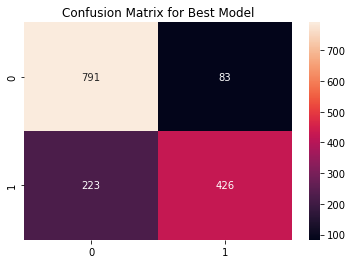

In [8]:
# Initialize variables for manual tuning
optimizers = ['adam', 'sgd']
dropout_rates = [0.2, 0.4]
unit_sizes = [32] # Reduced unit sizes to match LSTM units

best_accuracy = 0
best_params = {}

# Proceed with the hyperparameter tuning
for optimizer in optimizers:
    for dropout_rate in dropout_rates:
        for units in unit_sizes:
            print(f"Training with optimizer={optimizer}, dropout_rate={dropout_rate}, units={units}")

            # Build the model, passing the input_shape and vocab size.
            model = build_model(input_shape=max_length, vocab_size=vocab_size, embedding_dim=embedding_dim, optimizer=optimizer, dropout_rate=dropout_rate, units=units)

            # Early stopping to prevent overfitting
            early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

            # Train the model
            history = model.fit(
                X_train_split, y_train_split,
                validation_data=(X_val, y_val),
                epochs=10, batch_size=32,
                callbacks=[early_stopping],
                verbose=0
            )

            # Evaluate the model
            val_accuracy = max(history.history['val_accuracy'])
            print(f"Validation Accuracy: {val_accuracy}")

            # Save the best model
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_params = {'optimizer': optimizer, 'dropout_rate': dropout_rate, 'units': units}
                best_model = model

print(f"Best Model Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_accuracy}")

# Evaluate the best model on the validation data
y_pred = (best_model.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, y_pred))
print(f"Final Accuracy on Validation Data: {accuracy_score(y_val, y_pred)}")

# Visualize the confusion matrix for the best model
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for Best Model")
plt.show()

###  Make predictions and create submission dataframe

In [9]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the tokenizer
tokenizer = pickle.load(open('tokenizer.pkl', 'rb'))

# Tokenize and pad the test data
X_test_seq = tokenizer.texts_to_sequences(test_data['text'])
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Make predictions on the test data
y_pred_test = (best_model.predict(X_test_padded) > 0.5).astype("int32")

# Create the submission DataFrame
submission = pd.DataFrame({'id': test_data['id'], 'target': y_pred_test.flatten()})

# Save the submission to a CSV file
submission.to_csv('submission.csv', index=False)

print("submission.csv created successfully!")

102/102 [==============================] - 6s 59ms/step
submission.csv created successfully!


# Conclusion

The hyperparameter tuning process provided an accuracy of 80.1% using the Bidirectional LSTM model. This performance is not exceptionally high, but demonstrates the model's ability to discern between disaster-related and non-disaster tweets with a reasonable degree of accuracy. The confusion matrix indicates that there is a tendency to have more false positives than false negatives. The preciion and recall scores indicate a balanced performance. The model demostrated slightly better precision for non-disaster tweets and better recall for disaster tweets.

## Takeaway

The primary takeaway from this project is the feasibility of using Bidirectional LSTM networks for binary text classification in the context of social media data. The model was able to learn patterns from the tweet text, achieving a level of performance that could be useful in real-world scenarios. However, the confusion martix showed higher number of false positives, which suggests that the model may be oversensitive to certain words.This type of data is crucial for refining the model.

### Recommendations

**Address False Positives**: Given the higher rate of false positives, further investigation into the types of tweets being misclassified is warranted. Techniques such as adding more negative examples during training, adjusting the classification threshold, or incorporating additional features (e.g., keyword analysis, sentiment analysis) could help mitigate this issue.

**Explore Advanced Architectures**: While the Bidirectional LSTM model provided a solid baseline, exploring more advanced architectures like Transformer-based models (e.g., DistilBERT, RoBERTa) could potentially yield higher accuracy. These models have shown state-of-the-art performance in various NLP tasks, including text classification.

**Feature Engineering**: Enhancing the feature set by incorporating metadata (e.g., location, user information) or external data sources could provide the model with additional context, improving its ability to classify tweets accurately.

**Error Analysis**: Conduct a thorough error analysis to identify specific patterns or linguistic features that are causing misclassifications. This analysis can guide further model improvements and feature engineering efforts.

**Cross-Validation**: Implement a more robust cross-validation strategy to ensure the model's performance generalizes well to unseen data. This will provide a more reliable estimate of the model's true performance.

**Real-World Testing**: Deploy the model in a controlled real-world environment to assess its performance and identify potential issues. This will provide valuable feedback for further model refinement and optimization.